In [54]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy
from scipy.optimize import minimize

import bspline
import bspline.splinelab as splinelab
import time
import pandas as pd
import warnings
import cvxpy as cp
import QuantLib as ql
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Term Structure + Utils #

In [55]:
""" Generate calibration_report after HW fitting """
def calibration_report(swaptions, vols_data):
    
    columns = ["Model Price", "Market Price", "Implied Vol", "Market Vol", "Rel Er\
    ror Price", "Rel Error Vols", "Expiry", "Maturity"]
    
    report_data = []
    cum_err = 0.0
    cum_err2 = 0.0
    
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = vols_data[i]['vol']
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
        1e-1, 50, 0, 1.00)
     
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error*rel_error
        cum_err2 += rel_error2*rel_error2
        report_data.append((model_price, black_price, implied_vol, market_vol, rel_error, rel_error2, vols_data[i]['expiry'], vols_data[i]['maturity']))
        
    #print("Cumulative Error Price: %7.5f" % math.sqrt(cum_err))
    #print("Cumulative Error Vols : %7.5f" % math.sqrt(cum_err2))
    
    return pd.DataFrame(report_data,columns= columns, index=['']*len(report_data))

""" Term Structure handler, intialized via calibration against swaptions and 
              connstruction from liquid instruments"""
## Term Structure Model ##
class TS:
    def __init__(self, calibration_path, vols_path, payment_periods, tstart, num_paths, notional):
        self.discountBoundPaths = None
        self.num_paths = num_paths
        self.term_structure = self.build_curve(calibration_path, tstart);
        self.calibrated_model, gauss_generator = self.calibrate(vols_path, notional, payment_periods)
        _, self.short_rate_paths = self.generate_paths(num_paths, gauss_generator)
        #plt.plot(self.short_rate_paths.T)
        
    def generate_paths(self, num_paths, seq):
        timestep = 5400
        arr = np.zeros((num_paths, timestep+1))
        for i in range(num_paths):
            sample_path = seq.next()
            path = sample_path.value()
            time = [path.time(j) for j in range(len(path))]
            value = [path[j] for j in range(len(path))]
            arr[i, :] = np.array(value)
        return np.array(time), arr   
    
    def build_curve(self, calibration_path, tstart):
        df = pd.read_csv(calibration_path)
        data = []
        for i in range(len(df)):
            dt = dict(df.loc[i])
            dt['Date'] = '2023-06-30 00:00:00'
            data.append(dt)

        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        zeros = []
        deposits = ['1M', '3M', '6M', '12M']
        swaps = ['2Y', '3Y', '5Y', '7Y', '10Y', '15Y', '20Y', '30Y']
        for row in data[tstart:tstart+1]:
          
            # Build Curve for the date
            curve_date = ql.Date(row['Date'][:10], '%Y-%m-%d')
            ql.Settings.instance().evaluationDate = curve_date
            spot_date = calendar.advance(curve_date, 0, ql.Days) # beginning of eval - 2 days forward
            helpers = ql.RateHelperVector()
            for tenor in deposits:
                index = ql.USDLibor(ql.Period(tenor))
                helpers.append(
                    ql.DepositRateHelper(row[tenor] / 100, index)
                )
            for tenor in swaps:
                swap_index = ql.UsdLiborSwapIsdaFixAm(ql.Period(tenor))
                helpers.append(
                    ql.SwapRateHelper(row[tenor] / 100, swap_index)
                )
            curve = ql.PiecewiseCubicZero(curve_date, helpers, ql.Actual360())
        curve.enableExtrapolation()
        term_structure = ql.YieldTermStructureHandle(curve)
        return term_structure

    def calibrate(self, vols_path, notional, payment_periods):
      
        timestep = 5400
        model = ql.HullWhite(self.term_structure);
        engine = ql.JamshidianSwaptionEngine(model)

        index = ql.Euribor6M(self.term_structure)
        fixedLegTenor = ql.Period(payment_periods, ql.Months) # originally 1Y
        fixedLegDayCounter = ql.Actual360()
        floatingLegDayCounter = ql.Actual360()

        ## Grab volatilities ##
        df  = pd.read_csv(vols_path)
        date1 = df.loc[tstart] # Index important here
        volcub = np.reshape(date1[1:].values, (7,2))
        tenor_labels = [_ for _ in [5, 10]]
        expiry_labels = [_ for _ in [1/12, 3/12, 6/12, 1, 2, 5, 10]]
        self.swaption_vols = pd.DataFrame(volcub, index=expiry_labels, columns=tenor_labels)
        swaptions = []
        ql.Settings.instance().evaluationDate = ql.Date(30, 6, 2023)
        vols_data = []
   
        cnt = 0
        for maturity in self.swaption_vols.index:
            for tenor in self.swaption_vols.columns:
                vol = self.swaption_vols.at[maturity, tenor] / 100
                if(vol != 0):
                        vols_data.append({'vol':vol, 'expiry':maturity, 'maturity':tenor})
                        volatility = ql.QuoteHandle(ql.SimpleQuote(vol))
                        helper = ql.SwaptionHelper(
                            ql.Period(int(maturity*12), ql.Months),
                            ql.Period(int(tenor), ql.Years),
                            volatility,
                            index,
                            fixedLegTenor,
                            fixedLegDayCounter,
                            floatingLegDayCounter,
                            self.term_structure,
                            ql.BlackCalibrationHelper.RelativePriceError,
                            ql.nullDouble(),
                            notional, # nominal
                            ql.ShiftedLognormal, # ShiftedLogn
                            0.00 #shift to make rates non-negative
                        )
                        helper.setPricingEngine(engine)
                        swaptions.append(helper)
                        glob[(maturity, tenor)] = cnt;
                        cnt += 1;
                    
                else:
                    raise ValueError("0 vol. provied!")
    

        optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
        end_criteria = ql.EndCriteria(500000, 1000, 1e-6, 1e-8, 1e-8)
        model.calibrate(swaptions, optimization_method, end_criteria)
        
        self.params = model.params()
        
        df = calibration_report(swaptions, vols_data)
        #display(df)
        
        sigma = self.params[1]
        a = self.params[0]
        length = 15 # in years
        day_count = ql.Thirty360(ql.Thirty360.BondBasis)
        todays_date =  ql.Date(30, 6, 2023)

        ql.Settings.instance().evaluationDate = todays_date

        hw_process = ql.HullWhiteProcess(self.term_structure, a, sigma)
        
        rng = ql.GaussianLowDiscrepancySequenceGenerator(ql.UniformLowDiscrepancySequenceGenerator(timestep))
        seq = ql.GaussianSobolPathGenerator(hw_process, length, timestep, rng, False)

        #rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
        #seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)
        
        self.swaptions = swaptions;
            
        return model, seq
    
    def ZCBCurve(self, t, k=None, sched=None):
        """ P(t, T) for all t, T """
        if(sched is None):
            raise ValueError("Payment schedule not provided!")
        sched = sched/360
        def discountBond(T, k):
            r = self.short_rate_paths[k,int(t*360)]
            return self.calibrated_model.discountBond(t, T, r)
        
        if(k is not None):
            path = self.short_rate_paths[k, :];
            PTt = [self.calibrated_model.discountBond(t, i+t, path[int(t*360)]) for i in sched] #path[int(t*12)]
            return PTt;

        ts = sched + t
        ks = np.arange(self.num_paths)
        T, K = np.meshgrid(ts, ks)
        PTts = np.fromiter(map(discountBond, T.ravel(), K.ravel()), T.dtype).reshape(T.shape)
        self.discountBondPaths = PTts
        num_traj, traj_length = PTts.shape
        PTtsAvg = np.mean(PTts, axis=0)
        
        return PTtsAvg
    
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]

    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = np.array((this_dS ** 2)).reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)

    return A_mat

# Computes optimal hedges along with function_A_vec
def function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat, gamma, risk_lambda):
    tmp = Pi_hat.loc[:,t+1].values * delta_S_hat.loc[:, t].values
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)

    return B_vec

# Computes optimal Q-table via backward solve
def function_C_vec(t, data_mat, reg_param):
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat

# Computes optimal Q-table via backward solve
def function_D_vec(t, Q, R, data_mat, gamma):
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])

    return D_vec

# Computes terminal payoff of swaption as positive part of swaption payoff (redundant)
def terminal_payoff(K, x): #so
    # ST   final stock price
    # K    strike - not used
    payoff = max(x,0)
    return payoff

# Vanilla Swap #

In [56]:
"""Handler for underlying swap"""
class swap:
    def __init__(self, forward_time, maturity, fixed_sched, floating_sched, fixed_rate, tau_n, notional, tsobject, tstart, N_MC=100):

        self.forward_time = forward_time;
        self.maturity = maturity;
        self.fixed_sched = fixed_sched;
        self.floating_sched = floating_sched;
        self.fixed_rate = fixed_rate;
        self.tau_n = tau_n;
        self.notional = notional
        self.rates = np.zeros((N_MC, 24))
        
        num_paths = N_MC
        #tstart = 0
        self.tsh = tsobject
        
        self.term_structure = self.advance_dynamics(0)
        if(fixed_rate is None):
            A = sum([self.term_structure[i] for i in range(len(self.term_structure)-1)])
            B = sum([self.term_structure[i+1] for i in range(len(self.term_structure)-1)])
            self.fixed_rate = (A-B)/(self.tau_n*B)
        else:
            self.fixed_rate = fixed_rate
        #print("Value at zero = ", self.value_at_t(0))
        #plt.figure(1)
        #plt.plot(tau, self.term_structure)
        #print("params = ", term.par)

    def advance_dynamics(self, t, k=None):
        sched = self.fixed_sched + (self.forward_time - t)*360
        p = self.tsh.ZCBCurve(t, k, sched);
        return p

    def value_at_t(self, t, k=None):

        # calibrate to current time t #
        term_structure = self.advance_dynamics(t, k)
        v_swap = 0;
        annuity = sum(term_structure)*self.tau_n 
        for i in range(0, len(term_structure)-1):
            v_swap += (term_structure[i] - term_structure[i+1] - self.tau_n*self.fixed_rate*term_structure[i+1])
        if(k is not None):
            indx = int((23*t)/self.forward_time)
            self.rates[k, indx] = ((v_swap)/annuity + self.fixed_rate)
        return v_swap*self.notional # (swap value, swap rate)
    
    def payoff(self):
        return max(self.value_at_t(self.forward_time), 0)


# European Swaption

In [57]:
''' Handler for european underlying bermudan exerise swaptions '''
class european:
    def __init__(self,
                 file_path,
                 forward_time,
                 maturity,
                 notional,
                 tsobject,
                 fixed_rate = None,
                 payment_periods = 6,
                 tau_n = 1/2,
                 N_MC = 1000,
                 tstart = 0, 
                 verbose=False,
                 r = 0.03,
                 K = 0,
                 risk_lambda = 0.001):

        idx_plot = np.arange(0, N_MC, 500)
        trajectories, rates, s1 = self.run_sim(forward_time, maturity, fixed_rate, N_MC, notional, tsobject, tau_n, payment_periods, tstart)
        
        if(verbose):
            plt.figure(1)
            plt.title("Underlying Swap Value vs Timestep")
            plt.xlabel("Timestep")
            plt.ylabel("Swap Value")
            plt.plot(trajectories[idx_plot].T)
        
        risk_lambda = 0.001 # risk aversion 0.001
        K = 0         # option stike
        r = 0.03 # risk-free-rate
        T =  24 - 1
        # Note that we set coef=0 below in function function_B_vec. This correspond to a pure risk-based hedging
        
        '''----------------------------------------------------------------------------------------------------------------------'''
        ## Get swaption index ##
        tenor_labels = [_ for _ in [2, 5, 10]]
        expiry_labels = [_ for _ in [1/12, 3/12, 6/12, 1, 2, 5, 10]]
        key = (forward_time, maturity)
        if(key not in glob.keys()):
            key = (1/12, 5)
        ind = glob[key]
        ##

        ## Validate monte carlo estimate with analytical
        muv  = np.maximum(np.array(trajectories)[:, -1], 0)

        dF = np.exp(-np.sum(np.array(s1.tsh.short_rate_paths[:, 0:int(forward_time*360)]), axis=1)*1/360)
        mcest = np.average(np.multiply(muv, dF))*N_MC
        trt = s1.tsh.swaptions[ind].modelValue()
        '''----------------------------------------------------------------------------------------------------------------------'''

        S = np.array(trajectories
        )
        delta_t = tau_n # same as tau_n
        gamma = np.exp(- r * delta_t)  # discount factor
        delta_S = pd.DataFrame(S[:,1:int(T)+1]- np.exp(r * delta_t) * S[:,0:int(T) + 1-1])
        delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)
        S = pd.DataFrame(S)
        
        X = S
        X_min = np.min(np.min(X))
        X_max = np.max(np.max(X))


        p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
        ncolloc = 12

        tau = np.linspace(X_min,X_max,ncolloc)  
        k = splinelab.aptknt(tau, p)

        basis = bspline.Bspline(k, p)

        num_t_steps = int(T)+1
        num_basis =  ncolloc # len(k) #

        data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

        t_0 = time.time()
        # fill it
        for i in np.arange(num_t_steps):
            x = X.values[:,i]
            data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

        t_end = time.time()

        '''----------------------------------------------------------------------------------------------------------------------'''

        starttime = time.time()
        # portfolio value
        Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
        Pi[Pi.columns[-1]] = S[S.columns[-1]].apply(lambda x: terminal_payoff(K, x)).values
        Pi = Pi.replace(np.nan, 0)
        Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
        Pi_hat[Pi_hat.columns[-1]] = Pi[Pi.columns[-1]] - np.mean(Pi.iloc[:,-1])

        Pi_hat = Pi_hat.replace(np.nan, 0)

        # optimal hedge
        a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
        a = a.replace(np.nan, 0)
        a.iloc[:,-1] = 0

        reg_param = 1e-3 # free parameter
        prev = np.zeros((N_MC, ))
        lmbda = 0.1

        for t in range(int(T)-1, -1, -1):


            A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param) # OG
            B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda) # OG
            phi, _ = scipy.sparse.linalg.cg(A_mat, B_vec) #np.dot(np.linalg.inv(A_mat), B_vec) # OG
            tentative =  np.dot(data_mat_t[t,:,:],phi)
            #if(np.linalg.norm(tentative, np.inf) > 0.01):
            #    tentative = a[a.columns[t+1]]
            a[a.columns[t]] = tentative # OG
            Pi[Pi.columns[t]] = gamma * (Pi.loc[:,t+1].values - a.loc[:,t].values * delta_S.loc[:,t].values) # OG
            Pi_hat[Pi_hat.columns[t]] = Pi.loc[:,t].values - np.mean(Pi.loc[:,t]) # 0G

        a = a.astype('float')
        Pi = Pi.astype('float')
        Pi_hat = Pi_hat.astype('float')

        endtime = time.time()

        '''----------------------------------------------------------------------------------------------------------------------'''

        #Compute rewards for all paths
        starttime = time.time()
        # reward function
        R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
        normalize = np.mean(Pi.iloc[:, -1].values) if np.mean(Pi.iloc[:, -1].values) != 0 else 1
        R[R.columns[-1]] = -risk_lambda * np.var(Pi.iloc[:,-1].values) /np.mean(Pi.iloc[:,-1].values)
        for t in range(int(T)):
            vals = Pi.loc[1:, t].replace(np.nan, 0)
            #normalize = np.mean(vals.values) if np.mean(vals.values) != 0 else 1
            R.iloc[:, t] = gamma * a.loc[1:,t].values * delta_S.loc[:,t].values - risk_lambda * np.var(vals.values) /np.mean(vals.values)

        endtime = time.time()

        '''----------------------------------------------------------------------------------------------------------------------'''
        if(verbose):
            plt.figure(2)
            plt.plot(a.T.iloc[:,idx_plot])
            plt.xlabel('Time Steps')
            plt.title('Optimal Hedge')
            plt.show()

            plt.figure(3)
            plt.plot(Pi.T.iloc[:,idx_plot])
            plt.xlabel('Time Steps')
            plt.title('Portfolio Value')
            plt.show()
        '''----------------------------------------------------------------------------------------------------------------------'''
        
        starttime = time.time()
        # Q function
        Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
        Q[Q.columns[-1]] = - Pi[Pi.columns[-1]] - risk_lambda * np.var(Pi.iloc[:,-1]) /np.mean(Pi.iloc[:,-1])
        reg_param = 1e-3

        for t in range(int(T)-1, -1, -1):

            C_mat = function_C_vec(t,data_mat_t,reg_param)
            D_vec = function_D_vec(t, Q,R,data_mat_t,gamma)
            omega = np.dot(np.linalg.inv(C_mat), D_vec)

            Q[Q.columns[t]] = np.dot(data_mat_t[t,:,:], omega)

        Q = Q.astype('float')

        endtime = time.time()

        '''----------------------------------------------------------------------------------------------------------------------'''
        if(verbose):
            plt.figure(4)
            # plot 10 paths
            plt.plot(Q.T.iloc[:, idx_plot])
            plt.xlabel('Time Steps')
            plt.title('Optimal Q-Function')
            plt.show()
        
        
        # QLBS option price
        C_QLBS = - Q.copy()
        qp = np.average(C_QLBS.iloc[:,0])
        bp = s1.tsh.swaptions[ind].blackPrice(s1.tsh.swaption_vols.at[key[0], key[1]]/100) #
        mp = s1.tsh.swaptions[ind].modelValue() #
        rel_model = 100*(qp/mp - 1)
        rel_black = 100*(qp/bp - 1)
        rel_mb = 100*(mp/bp - 1)
        rel_mc = 100*(mcest/trt - 1)
        rel_not = 100*abs(qp-mp)/notional
        if(verbose):
            print('-------------------------------------------')
            print('       QLBS Option Pricing (DP solution)      ')
            print('-------------------------------------------\n')
            print('%-25s' % ('Notional:'), notional)
            print('%-25s' % ('Expiry of option (yrs)'), forward_time)
            print('%-25s' % ('Maturity of underlying (yrs):'), maturity)
            print('Tenor (payment) structure  every %d ' % (payment_periods) + '(days)')
            print('%-25s' % ('Risk-free rate: '), r)
            print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
            print('%-25s' % ('Strike:'), K)
            print('%-25s' % ('Fixed rate:'), s1.fixed_rate)
            print('%-25s' % ('# Trajectories:'), N_MC)
            print('%-26s %.4f' % ('\nQLBS Put Price: ', qp))
            print('%-26s %.4f' % ('Black Put Price: ', bp))
            print('%-26s %.4f' % ('Model Put Price: ', mp)) 
            print('%-26s %.4f' % ('\nRel. error (MC to analytical): ', rel_mc) + " %")
            print('%-26s %.4f' % ('Rel. error (to black): ', rel_black) + " %")
            print('%-26s %.4f' % ('Rel. error (to model): ', rel_model) + " %")
            print('%-26s %.4f' % ('Rel. error (model to black): ', rel_mb) + " %")
            print('%-26s %.4f' % ('Rel. error (to notional): ', rel_not) + " %")

        self.s1 = s1;
        self.trajectories = trajectories
        self.payoff = s1.payoff()
        self.price = qp;
        self.err = rel_model if (abs(rel_model) < abs(rel_black)) else rel_black
        self.err_not = rel_not
        self.err_mc = rel_mc
    
    def run_sim(self, forward_time, maturity, fixed_rate, N_MC, notional, tsobject, tau_n, payment_periods, tstart):
        fixed_sched = np.arange(0, maturity*360 + 2*payment_periods, payment_periods)
        floating_sched = fixed_sched;
        tau_n = tau_n
        s1 = swap(forward_time, maturity, fixed_sched, floating_sched, fixed_rate, tau_n, notional, tsobject, tstart, N_MC)
        rates = []
        
        xs = np.linspace(0, forward_time, 24)
        ys = np.arange(0, N_MC)
        X, Y = np.meshgrid(xs, ys)
        
        starttime = time.time()
        trajectories = np.fromiter(map(s1.value_at_t, X.ravel(), Y.ravel()), X.dtype).reshape(X.shape)
        print("Completed meshgrid computation in " + str(time.time() - starttime) + " seconds")
        
        return trajectories, rates, s1

Time to build Term Structure objct = 33.32653093338013 seconds
Completed meshgrid computation in 13.90924859046936 seconds


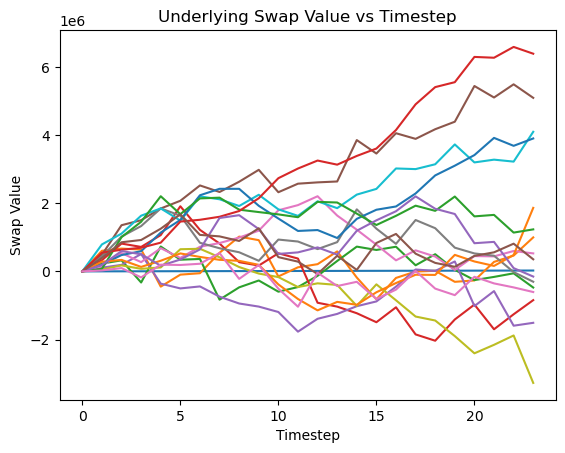

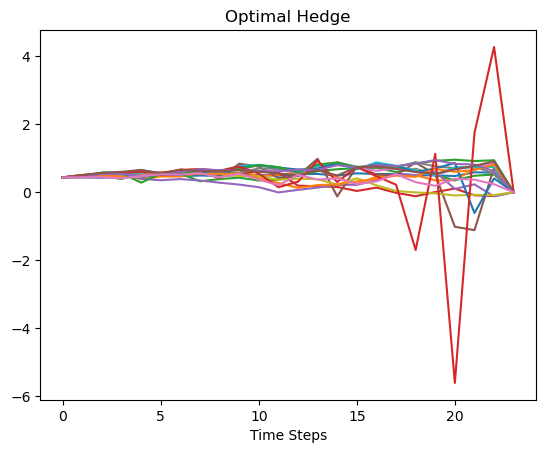

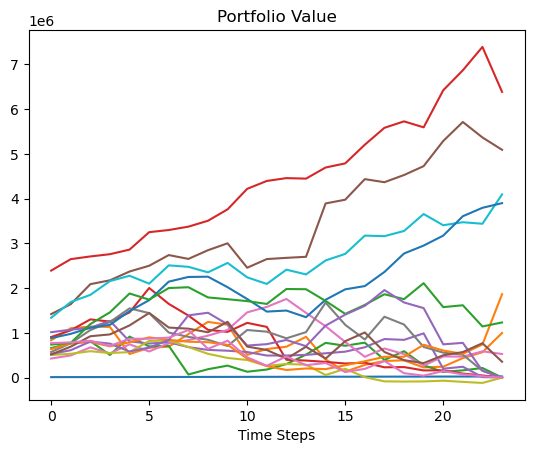

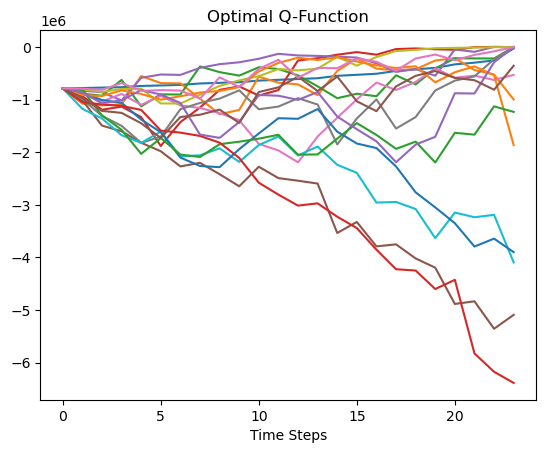

-------------------------------------------
       QLBS Option Pricing (DP solution)      
-------------------------------------------

Notional:                 100000000.0
Expiry of option (yrs)    0.08333333333333333
Maturity of underlying (yrs): 10
Tenor (payment) structure  every 90 (days)
Risk-free rate:           0.03
Risk aversion parameter:  0.001
Strike:                   0
Fixed rate:               0.029300241967419344
# Trajectories:           8192

QLBS Put Price:           787549.1625
Black Put Price:           927715.6102
Model Put Price:           940406.4806

Rel. error (MC to analytical):  735566.0213 %
Rel. error (to black):     -15.1088 %
Rel. error (to model):     -16.2544 %
Rel. error (model to black):  1.3680 %
Rel. error (to notional):  0.1529 %

Payoff of swaption 483.277


In [52]:
## Single sample run with European swaption #
glob = dict()
forward_time = 1/12
maturity = 10
notional = 1e8
fixed_rate = None;
payment_periods = 3
payment_periods *= 30
tau_n = payment_periods/360
tstart = 0;
N_MC = 8192;

calibration_path = 'bloomberg_calibration.csv'
vols_path = 'vols_liquid.csv'
start = time.time()
tsobject = TS(calibration_path, vols_path, payment_periods, tstart, N_MC, notional)
print("Time to build Term Structure objct = " + str(time.time() - start) + " seconds")

bs = european(calibration_path, forward_time, maturity, notional, tsobject, fixed_rate, payment_periods, tau_n, N_MC,tstart, True)
print("\nPayoff of swaption %.3f" % bs.payoff)

# Bermudan Swaption

In [58]:
""" Handler for bermudan swaption pricing, i.e. basket of europeans"""
class bermudan():
    def __init__(self, file_path, bermudan_forward_time, bermudan_maturity, notional, payment_periods, tstart, N_MC=100):
        resets = np.arange(0, (bermudan_maturity)*360 + 2*payment_periods, payment_periods)
        self.basket = [];
        risk_free_discounts, swap_rates, payoffs, prices = self.populate_basket(resets, notional, payment_periods, bermudan_forward_time, bermudan_maturity, tstart, N_MC)
        continuation_values = self.continuation_ls(risk_free_discounts, swap_rates, payoffs); #change to prices
        self.price, self.black_error, self.notional_error = self.compute_price(resets, payoffs, continuation_values, prices, notional, bermudan_forward_time, bermudan_maturity, payment_periods, tstart, N_MC)
        
    # Constructs and values basket of europeans with varying forwads/maturities
    def populate_basket(self, resets, notional, payment_periods, bermudan_forward_time, bermudan_maturity, tstart, N_MC):
        value = 1;
        risk_free_discounts = []
        swap_rates = []
        
        tau_n = payment_periods/360; 
        fixed_rate = None;
        calibration_path = 'bloomberg_calibration.csv'
        vols_path = 'vols_liquid.csv'
        starttime = time.time()
        tsobject = TS(calibration_path, vols_path, payment_periods, tstart, N_MC, notional)
        print("Time to build Term Structure objct = " + str(time.time() - starttime) + " seconds")
        for idx in tqdm(range(len(resets[:-1]))):
            res = resets[:-1][idx]
            time.sleep(0.1)
            print("Populating basket with european swaption # %d" % (idx+1))
        
            path_forward_time = bermudan_forward_time + res/360
            path_maturity = bermudan_maturity - res/360
            bs = european(file_path,
                 path_forward_time,
                 path_maturity,
                 notional,
                 tsobject,
                 fixed_rate = None,
                 payment_periods = payment_periods,
                 tau_n = tau_n,
                 N_MC = N_MC,
                 tstart = tstart, 
                 verbose = False,
                 r = 0.03,
                 K = 0,
                 risk_lambda = 0.001)
            sched = np.array([path_forward_time*360, bermudan_forward_time*360 + resets[idx+1]])
            factors = bs.s1.tsh.ZCBCurve(0, None, sched)
            value = (bs.s1.tsh.discountBondPaths[:, 0] - 
                     bs.s1.tsh.discountBondPaths[:, 1])/(bs.s1.tsh.discountBondPaths[:, 1])
            risk_free_discounts.append(value)

            swap_rates.append(bs.s1.rates[:, -1])  
            self.basket.append(bs)
 
        # print("Risk-free discounts = ", risk_free_discounts)
        # print("Finished populating european swaption basket!")
        swap_rates = np.vstack(swap_rates).T
        print('\n----------------------------------------------------------------')
        print('       Finished accumulating basket of European swaptions!      ')
        print('----------------------------------------------------------------\n')
        payoffs = np.vstack([np.maximum(bs.trajectories[:,-1], 0) for bs in self.basket]).T;
        prices = [bs.price for bs in self.basket];
        return risk_free_discounts, swap_rates, payoffs, prices
    
    # Computes continuation values using Longstaff-Schwartz regression
    def continuation_ls(self, risk_free_discounts, swap_rates, payoffs):
        dim = len(self.basket) - 1
        cont = np.zeros_like(payoffs)
        cont[:, -1] = np.squeeze(payoffs[:, -1])
        for i in range(dim-1, -1, -1):
            A = np.vstack([swap_rates[:, i], swap_rates[:, i]**2, np.ones((1, N_MC))]).T
            b = risk_free_discounts[i]*cont[:, i+1]
            theta = np.linalg.lstsq(A, b)[0]
            cont[:, i] = np.squeeze(np.maximum(cont[:, i], A@theta))
        return np.average(cont, axis=1)
    
    # Backward-solves for prices at all exercise times
    def back_solve(self, prices, continuation_values, resets, bermudan_forward_time, payoffs):
        prices_dp = prices.copy()
        for i in np.arange(len(prices) - 2, -1, -1):
            T0 = resets[i] + int(360*bermudan_forward_time)
            discountToZero = np.average(np.exp(-np.sum(np.array(self.basket[i].s1.tsh.short_rate_paths[:, 0:T0]), axis=1)*1/360))
            prices_dp[i] = max(prices_dp[i], continuation_values[i]);
        return prices_dp[0]
    
    # Computes analytical price using QuantLib TreeSwaption Engine
    def price_ql(self, tforward, maturity, notional, payment_periods, tstart, N_MC):
        
        calibration_path = 'bloomberg_calibration.csv'
        vols_path = 'vols_liquid.csv'
        tsh = TS(calibration_path, vols_path, payment_periods, tstart, N_MC, notional)

        termStructure = tsh.term_structure
        model = tsh.calibrated_model

        calendar = ql.TARGET();
        settlementDate = ql.Date(30, ql.June, 2023)

        swapEngine = ql.DiscountingSwapEngine(termStructure) ## subs. needed

        fixedLegFrequency = ql.Semiannual #Semi
        fixedLegTenor = ql.Period(payment_periods, ql.Months)
        fixedLegConvention = ql.Unadjusted

        floatingLegConvention = ql.ModifiedFollowing
        fixedLegDayCounter = ql.Thirty360(ql.Thirty360.European);
        floatingLegFrequency = ql.Semiannual
        floatingLegTenor = ql.Period(payment_periods, ql.Months)

        payFixed = ql.VanillaSwap.Payer
        fixingDays = 0;
        index = ql.Euribor6M(termStructure) ## subs. needed
        floatingLegDayCounter = index.dayCounter();


        swapStart = calendar.advance(settlementDate, int(tforward*12), ql.Months, floatingLegConvention)
        swapEnd = calendar.advance(swapStart, maturity, ql.Years, floatingLegConvention)

        fixedSchedule=  ql.Schedule(swapStart, swapEnd, fixedLegTenor, calendar, fixedLegConvention, fixedLegConvention, 
                                    ql.DateGeneration.Forward, False);
        floatingSchedule = ql.Schedule(swapStart, swapEnd, floatingLegTenor, calendar, floatingLegConvention, floatingLegConvention,
                                      ql.DateGeneration.Forward, False)

        dummy = ql.VanillaSwap(payFixed, 100.0, 
                           fixedSchedule, 0.0, fixedLegDayCounter, floatingSchedule, 
                           index, 0.0, floatingLegDayCounter)
        dummy.setPricingEngine(swapEngine)
        atmRate = dummy.fairRate()

        atmSwap = ql.VanillaSwap(payFixed, notional, 
                                 fixedSchedule, atmRate, fixedLegDayCounter, 
                                 floatingSchedule, index, 0.0, 
                                 floatingLegDayCounter)
        atmSwap.setPricingEngine(swapEngine)

        """ --- """

        bermudanDates = [d for d in fixedSchedule][:-1]
        exercise = ql.BermudanExercise(bermudanDates)

        atmSwaption = ql.Swaption(atmSwap, exercise);
        atmSwaption.setPricingEngine(ql.TreeSwaptionEngine(model, 50)) # subs. needed
        price = atmSwaption.NPV()
        return price
    
    # Summarizes run results #
    def compute_price(self, resets, payoffs, continuation_values, prices, notional, bermudan_forward_time, bermudan_maturity, payment_periods, tstart, N_MC):
        price = self.back_solve(prices, continuation_values, resets, bermudan_forward_time, payoffs)
        actual = self.price_ql(bermudan_forward_time, bermudan_maturity, notional, payment_periods, tstart, N_MC)
        black_error = 100 * ((price/actual) - 1)
        notional_error = 100 * abs(price-actual)/notional
        print('----------------------------------------------------------------')
        print('*******************************************')
        print('       QLBS Option Pricing (DP solution)      ')
        print('*******************************************\n')
        print('%-25s' % ('Notional:'), notional)
        print('%-25s' % ('Forward time of underlying (yrs)'), bermudan_forward_time)
        print('%-25s' % ('Maturity of underlying (yrs):'), bermudan_maturity)
        print('Tenor (payment) structure  every %d' %(payment_periods)  + ' (days)')
        print('%-26s %.4f' % ('\nQLBS Bermudan Put Price: ', price))
        print('%-26s %.4f' % ('QuantLib Bermudan Put Price: ', actual))
        print('%-26s %.4f' % ('Rel. error (to model): ', black_error) + " %")
        print('%-26s %.4f' % ('Rel. error (to notional): ', notional_error) + " %")
        print('----------------------------------------------------------------')
        return price, black_error, notional_error 




In [59]:
glob = dict()
file_path = 'bloomberg_calibration.csv'
tforward = 1/12;
maturity = 5;
payment_periods = 6;
payment_periods *= 30
notional = 1e8
tstart = 0;
N_MC = 8192;
bp1 = bermudan(file_path, tforward, maturity, notional, payment_periods, tstart, N_MC)

Time to build Term Structure objct = 32.18940615653992 seconds


  0%|                                                                                  | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 4.953742027282715 seconds


  9%|██████▋                                                                   | 1/11 [00:25<04:11, 25.14s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 4.537675619125366 seconds


 18%|█████████████▍                                                            | 2/11 [00:49<03:44, 24.97s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.31508469581604 seconds


 27%|████████████████████▏                                                     | 3/11 [01:14<03:17, 24.64s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 3.929749011993408 seconds


 36%|██████████████████████████▉                                               | 4/11 [01:37<02:48, 24.12s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.6304614543914795 seconds


 45%|█████████████████████████████████▋                                        | 5/11 [02:00<02:21, 23.66s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.3697333335876465 seconds


 55%|████████████████████████████████████████▎                                 | 6/11 [02:23<01:56, 23.32s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.0952229499816895 seconds


 64%|███████████████████████████████████████████████                           | 7/11 [02:46<01:32, 23.22s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.952207565307617 seconds


 73%|█████████████████████████████████████████████████████▊                    | 8/11 [03:08<01:08, 22.89s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.5522687435150146 seconds


 82%|████████████████████████████████████████████████████████████▌             | 9/11 [03:30<00:45, 22.55s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.2673962116241455 seconds


 91%|██████████████████████████████████████████████████████████████████▎      | 10/11 [03:51<00:22, 22.21s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.011859893798828 seconds


100%|█████████████████████████████████████████████████████████████████████████| 11/11 [04:12<00:00, 22.95s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 0.08333333333333333
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  435503.1244
QuantLib Bermudan Put Price:  397765.4948
Rel. error (to model):     9.4874 %
Rel. error (to notional):  0.0377 %
----------------------------------------------------------------


# Exp. Run - European

In [30]:
## multi- sample run with European swaption #
glob = dict()
forward_terms = [1/12, 3/12, 6/12, 1, 2, 5, 10]
expiry_terms = [5, 10]
results_model = np.zeros((len(forward_terms), len(expiry_terms)))

N_MC = 8192;   
calibration_path = 'bloomberg_calibration.csv'
vols_path = 'vols_liquid.csv'
start = time.time()
tsobject = TS(calibration_path, vols_path, payment_periods, tstart, N_MC, notional)
print("Time to build Term Structure objct = " + str(time.time() - start) + " seconds")

results_not = np.zeros((len(forward_terms), len(expiry_terms)))
for i in range(len(forward_terms)):
    for j in range(len(expiry_terms)):
        file_path = 'bloomberg_calibration.csv'
        forward_time = forward_terms[i]
        maturity = expiry_terms[j]
        notional = 1e8
        fixed_rate = None
        payment_periods = 3
        payment_periods *= 30
        tau_n = payment_periods/360
        tstart = 0;
        bs = european(file_path, forward_time, maturity, notional, tsobject, fixed_rate, payment_periods, tau_n, N_MC, tstart, True)
        print("\nPayoff of swaption %.3f" % bs.payoff)
        results_model[i,j] = bs.err
        results_not[i,j] = bs.err_mc

Time to build Term Structure objct = 31.938373565673828 seconds
Completed meshgrid computation in 7.787952184677124 seconds
-------------------------------------------
       QLBS Option Pricing (DP solution)      
-------------------------------------------

Notional:                 100000000.0
Expiry of option (yrs)    0.08333333333333333
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 90 (days)
Risk-free rate:           0.03
Risk aversion parameter:  0.001
Strike:                   0
Fixed rate:               0.031452110359768116
# Trajectories:           8192

QLBS Put Price:           474699.5876
Black Put Price:           574219.5575
Model Put Price:           546811.5114

Rel. error (MC to analytical):  763223.5309 %
Rel. error (to black):     -17.3313 %
Rel. error (to model):     -13.1877 %
Rel. error (model to black):  -4.7731 %
Rel. error (to notional):  0.0721 %

Payoff of swaption 134.321
Completed meshgrid computation in 13.578376770019531 seconds
-------


Payoff of swaption 140393.284
Completed meshgrid computation in 7.819788694381714 seconds
-------------------------------------------
       QLBS Option Pricing (DP solution)      
-------------------------------------------

Notional:                 100000000.0
Expiry of option (yrs)    5
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 90 (days)
Risk-free rate:           0.03
Risk aversion parameter:  0.001
Strike:                   0
Fixed rate:               0.026645704359242076
# Trajectories:           8192

QLBS Put Price:           3148611.3613
Black Put Price:           3243641.9805
Model Put Price:           3214855.3287

Rel. error (MC to analytical):  784449.3226 %
Rel. error (to black):     -2.9298 %
Rel. error (to model):     -2.0606 %
Rel. error (model to black):  -0.8875 %
Rel. error (to notional):  0.0662 %

Payoff of swaption 479524.056
Completed meshgrid computation in 13.826213836669922 seconds
-------------------------------------------
       QLB

In [31]:
mat = [('Underlying Swap Tenor', str(_)) for _ in expiry_terms]
exp = [('Option Expiry', str(_)) for _ in forward_terms]
df0 = pd.DataFrame(data=results_model, columns = pd.MultiIndex.from_tuples(mat),
                 index=pd.MultiIndex.from_tuples(exp))
df1 = pd.DataFrame(data=results_not, columns = pd.MultiIndex.from_tuples(mat),
                 index=pd.MultiIndex.from_tuples(exp))
display(df0)
display(df1)

Underlying Swap Tenor           
                                                      5         10
Option Expiry 0.08333333333333333            -13.187711 -15.108773
              0.25                           -12.986754 -15.324493
              0.5                            -10.096710 -14.273928
              1                               -0.683714 -10.271061
              2                               -7.364534 -11.054025
              5                               -2.060558  -5.962611
              10                               3.572187  -0.043988

Underlying Swap Tenor               
                                                      5             10
Option Expiry 0.08333333333333333         763223.530874  735566.021312
              0.25                        766088.136370  738039.147682
              0.5                         777761.172167  748277.546158
              1                           788392.894762  755864.477833
              2                           790444.616843  757997.835255
              5                           784449.322622  752522.829130
              10                          786165.004013  761401.494281

# Exp. Run - Bermudan

In [32]:
# Run #
glob = dict()
forward_terms = [1/12, 3/12, 6/12, 1, 2, 5, 10]
expiry_terms = [5, 10]
results_black = np.zeros((len(forward_terms), len(expiry_terms)))
results_notional = np.zeros((len(forward_terms), len(expiry_terms)))
for i in range(len(forward_terms)):
    for j in range(len(expiry_terms)):
        try:
            file_path = 'bloomberg_calibration.csv'
            tforward = forward_terms[i];
            maturity = expiry_terms[j];
            payment_periods = 6
            payment_periods *= 30
            notional = 1e8
            tstart = 0;
            N_MC = 8192;
            bp1 = bermudan(file_path, tforward, maturity, notional, payment_periods, tstart, N_MC)
            err1 = bp1.black_error
            err2 = bp1.notional_error
        except:
            err1 = np.nan
            err2 = np.nan
        results_black[i, j] = err1
        results_notional[i, j] = err2

Time to build Term Structure objct = 31.687402963638306 seconds


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 4.899764537811279 seconds


  9%|███████▌                                                                           | 1/11 [00:25<04:11, 25.18s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 4.641735553741455 seconds


 18%|███████████████                                                                    | 2/11 [00:49<03:44, 24.89s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.40710186958313 seconds


 27%|██████████████████████▋                                                            | 3/11 [01:14<03:17, 24.71s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 4.104202032089233 seconds


 36%|██████████████████████████████▏                                                    | 4/11 [01:38<02:51, 24.49s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.7513012886047363 seconds


 45%|█████████████████████████████████████▋                                             | 5/11 [02:02<02:25, 24.22s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.514317750930786 seconds


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:25<01:59, 23.99s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.239500045776367 seconds


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:48<01:34, 23.71s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.9193458557128906 seconds


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:12<01:10, 23.51s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.7492892742156982 seconds


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:35<00:46, 23.36s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.3766322135925293 seconds


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:57<00:23, 23.07s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.0740039348602295 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:19<00:00, 23.58s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 0.08333333333333333
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  435503.1244
QuantLib Bermudan Put Price:  397765.4948
Rel. error (to model):     9.4874 %
Rel. error (to notional):  0.0377 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.774462938308716 seconds


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 7.791072368621826 seconds


  5%|███▉                                                                               | 1/21 [00:28<09:20, 28.04s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 7.460842132568359 seconds


 10%|███████▉                                                                           | 2/21 [00:55<08:49, 27.86s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 7.35211181640625 seconds


 14%|███████████▊                                                                       | 3/21 [01:23<08:22, 27.91s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 6.997023344039917 seconds


 19%|███████████████▊                                                                   | 4/21 [01:51<07:50, 27.68s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 6.613921642303467 seconds


 24%|███████████████████▊                                                               | 5/21 [02:17<07:17, 27.35s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 6.308099269866943 seconds


 29%|███████████████████████▋                                                           | 6/21 [02:44<06:46, 27.09s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 6.040785074234009 seconds


 33%|███████████████████████████▋                                                       | 7/21 [03:10<06:15, 26.80s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 5.797846794128418 seconds


 38%|███████████████████████████████▌                                                   | 8/21 [03:36<05:44, 26.52s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 5.491714715957642 seconds


 43%|███████████████████████████████████▌                                               | 9/21 [04:02<05:16, 26.35s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 5.439674377441406 seconds


 48%|███████████████████████████████████████                                           | 10/21 [04:29<04:51, 26.52s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 5.243916034698486 seconds


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:55<04:23, 26.34s/it]

Populating basket with european swaption # 12
Completed meshgrid computation in 4.819080591201782 seconds


 57%|██████████████████████████████████████████████▊                                   | 12/21 [05:20<03:54, 26.03s/it]

Populating basket with european swaption # 13
Completed meshgrid computation in 4.524451732635498 seconds


 62%|██████████████████████████████████████████████████▊                               | 13/21 [05:45<03:24, 25.58s/it]

Populating basket with european swaption # 14
Completed meshgrid computation in 4.043745994567871 seconds


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [06:09<02:55, 25.11s/it]

Populating basket with european swaption # 15
Completed meshgrid computation in 3.779981851577759 seconds


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [06:32<02:28, 24.67s/it]

Populating basket with european swaption # 16
Completed meshgrid computation in 3.4821696281433105 seconds


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [06:56<02:01, 24.35s/it]

Populating basket with european swaption # 17
Completed meshgrid computation in 3.394493818283081 seconds


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [07:19<01:36, 24.03s/it]

Populating basket with european swaption # 18
Completed meshgrid computation in 2.959634304046631 seconds


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [07:42<01:10, 23.66s/it]

Populating basket with european swaption # 19
Completed meshgrid computation in 2.630067825317383 seconds


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [08:05<00:46, 23.38s/it]

Populating basket with european swaption # 20
Completed meshgrid computation in 2.3473284244537354 seconds


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [08:27<00:23, 23.02s/it]

Populating basket with european swaption # 21
Completed meshgrid computation in 2.0888004302978516 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [08:49<00:00, 25.21s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 0.08333333333333333
Maturity of underlying (yrs): 10
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  697308.6384
QuantLib Bermudan Put Price:  709042.2077
Rel. error (to model):     -1.6548 %
Rel. error (to notional):  0.0117 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.633810997009277 seconds


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 4.909841537475586 seconds


  9%|███████▌                                                                           | 1/11 [00:24<04:09, 24.92s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 4.609116792678833 seconds


 18%|███████████████                                                                    | 2/11 [00:49<03:42, 24.72s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.341333627700806 seconds


 27%|██████████████████████▋                                                            | 3/11 [01:13<03:16, 24.50s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 4.059202432632446 seconds


 36%|██████████████████████████████▏                                                    | 4/11 [01:37<02:50, 24.37s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.735335350036621 seconds


 45%|█████████████████████████████████████▋                                             | 5/11 [02:01<02:25, 24.17s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.4519927501678467 seconds


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:25<01:59, 23.89s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.2113897800445557 seconds


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:48<01:34, 23.71s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.913266658782959 seconds


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:11<01:10, 23.41s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.6015124320983887 seconds


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:33<00:46, 23.13s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.3495566844940186 seconds


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:56<00:22, 22.88s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.0810585021972656 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:18<00:00, 23.50s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 0.25
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  742498.2858
QuantLib Bermudan Put Price:  792480.7930
Rel. error (to model):     -6.3071 %
Rel. error (to notional):  0.0500 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.92895746231079 seconds


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 7.765279531478882 seconds


  5%|███▉                                                                               | 1/21 [00:27<09:18, 27.93s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 7.42409348487854 seconds


 10%|███████▉                                                                           | 2/21 [00:55<08:47, 27.74s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 7.147505044937134 seconds


 14%|███████████▊                                                                       | 3/21 [01:22<08:15, 27.54s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 6.869278430938721 seconds


 19%|███████████████▊                                                                   | 4/21 [01:50<07:46, 27.47s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 6.631288766860962 seconds


 24%|███████████████████▊                                                               | 5/21 [02:17<07:20, 27.50s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 6.691319942474365 seconds


 29%|███████████████████████▋                                                           | 6/21 [02:45<06:53, 27.56s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 6.303778409957886 seconds


 33%|███████████████████████████▋                                                       | 7/21 [03:12<06:24, 27.43s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 6.032661437988281 seconds


 38%|███████████████████████████████▌                                                   | 8/21 [03:39<05:54, 27.28s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 6.236947298049927 seconds


 43%|███████████████████████████████████▌                                               | 9/21 [04:07<05:29, 27.42s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 5.458141803741455 seconds


 48%|███████████████████████████████████████                                           | 10/21 [04:33<04:58, 27.12s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 5.193576812744141 seconds


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:59<04:28, 26.84s/it]

Populating basket with european swaption # 12
Completed meshgrid computation in 4.814026355743408 seconds


 57%|██████████████████████████████████████████████▊                                   | 12/21 [05:26<04:00, 26.71s/it]

Populating basket with european swaption # 13
Completed meshgrid computation in 4.587912082672119 seconds


 62%|██████████████████████████████████████████████████▊                               | 13/21 [05:52<03:33, 26.65s/it]

Populating basket with european swaption # 14
Completed meshgrid computation in 4.311541795730591 seconds


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [06:18<03:03, 26.22s/it]

Populating basket with european swaption # 15
Completed meshgrid computation in 3.9311721324920654 seconds


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [06:42<02:34, 25.79s/it]

Populating basket with european swaption # 16
Completed meshgrid computation in 3.580709934234619 seconds


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [07:07<02:06, 25.36s/it]

Populating basket with european swaption # 17
Completed meshgrid computation in 3.4962666034698486 seconds


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [07:32<01:41, 25.33s/it]

Populating basket with european swaption # 18
Completed meshgrid computation in 2.9888968467712402 seconds


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [07:55<01:14, 24.78s/it]

Populating basket with european swaption # 19
Completed meshgrid computation in 2.7173938751220703 seconds


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [08:19<00:48, 24.26s/it]

Populating basket with european swaption # 20
Completed meshgrid computation in 2.4125874042510986 seconds


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [08:42<00:23, 23.89s/it]

Populating basket with european swaption # 21
Completed meshgrid computation in 2.2157154083251953 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [09:04<00:00, 25.94s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 0.25
Maturity of underlying (yrs): 10
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  1186265.3562
QuantLib Bermudan Put Price:  1210645.4870
Rel. error (to model):     -2.0138 %
Rel. error (to notional):  0.0244 %
----------------------------------------------------------------
Time to build Term Structure objct = 33.2876033782959 seconds


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 5.031071424484253 seconds


  9%|███████▌                                                                           | 1/11 [00:25<04:18, 25.89s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 5.009002685546875 seconds


 18%|███████████████                                                                    | 2/11 [00:52<03:56, 26.29s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.531871795654297 seconds


 27%|██████████████████████▋                                                            | 3/11 [01:17<03:24, 25.60s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 4.116663217544556 seconds


 36%|██████████████████████████████▏                                                    | 4/11 [01:41<02:56, 25.16s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.8351762294769287 seconds


 45%|█████████████████████████████████████▋                                             | 5/11 [02:05<02:28, 24.79s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.552180767059326 seconds


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:29<02:02, 24.46s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.4344704151153564 seconds


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:53<01:36, 24.19s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.982022762298584 seconds


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:16<01:11, 23.86s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.692152738571167 seconds


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:39<00:47, 23.63s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.826904058456421 seconds


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [04:03<00:23, 23.74s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.154111862182617 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:27<00:00, 24.34s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 0.5
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  1023757.6302
QuantLib Bermudan Put Price:  1215417.7293
Rel. error (to model):     -15.7691 %
Rel. error (to notional):  0.1917 %
----------------------------------------------------------------
Time to build Term Structure objct = 34.44009304046631 seconds


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 7.939055919647217 seconds


  5%|███▉                                                                               | 1/21 [00:29<09:47, 29.40s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 7.821792840957642 seconds


 10%|███████▉                                                                           | 2/21 [00:58<09:10, 28.99s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 7.517439365386963 seconds


 14%|███████████▊                                                                       | 3/21 [01:26<08:38, 28.83s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 7.225184202194214 seconds


 19%|███████████████▊                                                                   | 4/21 [01:55<08:06, 28.65s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 6.971961975097656 seconds


 24%|███████████████████▊                                                               | 5/21 [02:23<07:35, 28.49s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 6.573645353317261 seconds


 29%|███████████████████████▋                                                           | 6/21 [02:50<07:02, 28.14s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 6.354375600814819 seconds


 33%|███████████████████████████▋                                                       | 7/21 [03:18<06:30, 27.89s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 6.045891761779785 seconds


 38%|███████████████████████████████▌                                                   | 8/21 [03:45<05:59, 27.63s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 5.82815408706665 seconds


 43%|███████████████████████████████████▌                                               | 9/21 [04:12<05:28, 27.40s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 5.475251913070679 seconds


 48%|███████████████████████████████████████                                           | 10/21 [04:38<04:58, 27.10s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 5.0962865352630615 seconds


 52%|██████████████████████████████████████████▉                                       | 11/21 [05:04<04:27, 26.75s/it]

Populating basket with european swaption # 12
Completed meshgrid computation in 4.800466537475586 seconds


 57%|██████████████████████████████████████████████▊                                   | 12/21 [05:30<03:58, 26.51s/it]

Populating basket with european swaption # 13
Completed meshgrid computation in 4.592396974563599 seconds


 62%|██████████████████████████████████████████████████▊                               | 13/21 [05:56<03:29, 26.25s/it]

Populating basket with european swaption # 14
Completed meshgrid computation in 4.231039047241211 seconds


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [06:21<03:01, 25.92s/it]

Populating basket with european swaption # 15
Completed meshgrid computation in 4.003680944442749 seconds


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [06:46<02:33, 25.56s/it]

Populating basket with european swaption # 16
Completed meshgrid computation in 3.6042230129241943 seconds


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [07:09<02:05, 25.06s/it]

Populating basket with european swaption # 17
Completed meshgrid computation in 3.2672693729400635 seconds


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [07:33<01:38, 24.59s/it]

Populating basket with european swaption # 18
Completed meshgrid computation in 2.9798929691314697 seconds


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [07:57<01:12, 24.30s/it]

Populating basket with european swaption # 19
Completed meshgrid computation in 3.021089792251587 seconds


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [08:20<00:48, 24.02s/it]

Populating basket with european swaption # 20
Completed meshgrid computation in 2.4072747230529785 seconds


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [08:43<00:23, 23.64s/it]

Populating basket with european swaption # 21
Completed meshgrid computation in 2.167403221130371 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [09:05<00:00, 26.00s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 0.5
Maturity of underlying (yrs): 10
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  1659743.6117
QuantLib Bermudan Put Price:  1968788.1967
Rel. error (to model):     -15.6972 %
Rel. error (to notional):  0.3090 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.880825519561768 seconds


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 4.949054956436157 seconds


  9%|███████▌                                                                           | 1/11 [00:25<04:10, 25.02s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 4.662839651107788 seconds


 18%|███████████████                                                                    | 2/11 [00:49<03:43, 24.86s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.41309380531311 seconds


 27%|██████████████████████▋                                                            | 3/11 [01:14<03:16, 24.60s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 4.06479287147522 seconds


 36%|██████████████████████████████▏                                                    | 4/11 [01:38<02:50, 24.37s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.8069920539855957 seconds


 45%|█████████████████████████████████████▋                                             | 5/11 [02:01<02:24, 24.11s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.514150381088257 seconds


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:25<01:59, 23.89s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.227837324142456 seconds


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:48<01:34, 23.69s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.919358015060425 seconds


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:11<01:10, 23.48s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.686134099960327 seconds


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:33<00:46, 23.16s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.3825576305389404 seconds


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:57<00:23, 23.43s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.0958003997802734 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:20<00:00, 23.66s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 1
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  1444683.8069
QuantLib Bermudan Put Price:  1683318.7333
Rel. error (to model):     -14.1765 %
Rel. error (to notional):  0.2386 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.979878425598145 seconds


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 7.727523326873779 seconds


  5%|███▉                                                                               | 1/21 [00:27<09:17, 27.85s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 7.499638795852661 seconds


 10%|███████▉                                                                           | 2/21 [00:55<08:47, 27.76s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 7.133368730545044 seconds


 14%|███████████▊                                                                       | 3/21 [01:22<08:15, 27.51s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 6.822709083557129 seconds


 19%|███████████████▊                                                                   | 4/21 [01:49<07:44, 27.30s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 6.5923261642456055 seconds


 24%|███████████████████▊                                                               | 5/21 [02:16<07:13, 27.12s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 6.35347843170166 seconds


 29%|███████████████████████▋                                                           | 6/21 [02:43<06:43, 26.93s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 6.115219354629517 seconds


 33%|███████████████████████████▋                                                       | 7/21 [03:09<06:13, 26.71s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 5.752742767333984 seconds


 38%|███████████████████████████████▌                                                   | 8/21 [03:35<05:44, 26.52s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 5.471914768218994 seconds


 43%|███████████████████████████████████▌                                               | 9/21 [04:00<05:14, 26.18s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 5.257480144500732 seconds


 48%|███████████████████████████████████████                                           | 10/21 [04:26<04:45, 25.91s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 4.953324794769287 seconds


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:51<04:18, 25.80s/it]

Populating basket with european swaption # 12
Completed meshgrid computation in 4.647721290588379 seconds


 57%|██████████████████████████████████████████████▊                                   | 12/21 [05:16<03:49, 25.48s/it]

Populating basket with european swaption # 13
Completed meshgrid computation in 4.29559326171875 seconds


 62%|██████████████████████████████████████████████████▊                               | 13/21 [05:40<03:20, 25.10s/it]

Populating basket with european swaption # 14
Completed meshgrid computation in 4.098043203353882 seconds


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [06:04<02:53, 24.82s/it]

Populating basket with european swaption # 15
Completed meshgrid computation in 3.7838783264160156 seconds


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [06:28<02:27, 24.53s/it]

Populating basket with european swaption # 16
Completed meshgrid computation in 3.492628574371338 seconds


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [06:52<02:00, 24.19s/it]

Populating basket with european swaption # 17
Completed meshgrid computation in 3.232353448867798 seconds


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [07:15<01:35, 23.91s/it]

Populating basket with european swaption # 18
Completed meshgrid computation in 2.9520957469940186 seconds


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [07:38<01:10, 23.65s/it]

Populating basket with european swaption # 19
Completed meshgrid computation in 2.6269419193267822 seconds


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [08:01<00:46, 23.35s/it]

Populating basket with european swaption # 20
Completed meshgrid computation in 2.3317959308624268 seconds


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [08:23<00:22, 22.98s/it]

Populating basket with european swaption # 21
Completed meshgrid computation in 2.093402147293091 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [08:45<00:00, 25.01s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 1
Maturity of underlying (yrs): 10
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  2280921.2336
QuantLib Bermudan Put Price:  2944352.4979
Rel. error (to model):     -22.5323 %
Rel. error (to notional):  0.6634 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.799007415771484 seconds


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 4.947803974151611 seconds


  9%|███████▌                                                                           | 1/11 [00:25<04:12, 25.30s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 4.635574817657471 seconds


 18%|███████████████                                                                    | 2/11 [00:49<03:44, 24.92s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.3802571296691895 seconds


 27%|██████████████████████▋                                                            | 3/11 [01:14<03:17, 24.67s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 4.079092979431152 seconds


 36%|██████████████████████████████▏                                                    | 4/11 [01:38<02:51, 24.48s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.7898666858673096 seconds


 45%|█████████████████████████████████████▋                                             | 5/11 [02:02<02:26, 24.38s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.507615566253662 seconds


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:26<02:00, 24.05s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.189450263977051 seconds


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:49<01:34, 23.72s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.8792710304260254 seconds


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:11<01:10, 23.42s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.633958339691162 seconds


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:34<00:46, 23.19s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.335756778717041 seconds


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:56<00:22, 22.91s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.0615193843841553 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:18<00:00, 23.54s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 2
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  2052863.2874
QuantLib Bermudan Put Price:  2320558.7372
Rel. error (to model):     -11.5358 %
Rel. error (to notional):  0.2677 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.700283765792847 seconds


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 7.8061277866363525 seconds


  5%|███▉                                                                               | 1/21 [00:28<09:23, 28.19s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 7.453073263168335 seconds


 10%|███████▉                                                                           | 2/21 [00:55<08:49, 27.86s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 7.172821283340454 seconds


 14%|███████████▊                                                                       | 3/21 [01:22<08:15, 27.55s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 6.8846235275268555 seconds


 19%|███████████████▊                                                                   | 4/21 [01:50<07:45, 27.36s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 6.695099115371704 seconds


 24%|███████████████████▊                                                               | 5/21 [02:17<07:15, 27.25s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 6.460694074630737 seconds


 29%|███████████████████████▋                                                           | 6/21 [02:43<06:45, 27.03s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 6.077717304229736 seconds


 33%|███████████████████████████▋                                                       | 7/21 [03:09<06:14, 26.73s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 5.861358404159546 seconds


 38%|███████████████████████████████▌                                                   | 8/21 [03:36<05:45, 26.56s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 5.51824426651001 seconds


 43%|███████████████████████████████████▌                                               | 9/21 [04:01<05:15, 26.29s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 5.288857936859131 seconds


 48%|███████████████████████████████████████                                           | 10/21 [04:27<04:46, 26.06s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 4.993647336959839 seconds


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:52<04:17, 25.76s/it]

Populating basket with european swaption # 12
Completed meshgrid computation in 4.625632047653198 seconds


 57%|██████████████████████████████████████████████▊                                   | 12/21 [05:17<03:49, 25.47s/it]

Populating basket with european swaption # 13
Completed meshgrid computation in 4.379282236099243 seconds


 62%|██████████████████████████████████████████████████▊                               | 13/21 [05:41<03:21, 25.18s/it]

Populating basket with european swaption # 14
Completed meshgrid computation in 4.0651326179504395 seconds


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [06:05<02:54, 24.89s/it]

Populating basket with european swaption # 15
Completed meshgrid computation in 3.7828569412231445 seconds


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [06:29<02:27, 24.60s/it]

Populating basket with european swaption # 16
Completed meshgrid computation in 3.5156028270721436 seconds


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [06:53<02:01, 24.32s/it]

Populating basket with european swaption # 17
Completed meshgrid computation in 3.231328010559082 seconds


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [07:16<01:35, 23.96s/it]

Populating basket with european swaption # 18
Completed meshgrid computation in 2.958059549331665 seconds


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [07:39<01:10, 23.66s/it]

Populating basket with european swaption # 19
Completed meshgrid computation in 2.648916482925415 seconds


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [08:02<00:46, 23.39s/it]

Populating basket with european swaption # 20
Completed meshgrid computation in 2.3417367935180664 seconds


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [08:24<00:23, 23.04s/it]

Populating basket with european swaption # 21
Completed meshgrid computation in 2.087448835372925 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [08:46<00:00, 25.08s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 2
Maturity of underlying (yrs): 10
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  3241048.7742
QuantLib Bermudan Put Price:  4093499.6893
Rel. error (to model):     -20.8245 %
Rel. error (to notional):  0.8525 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.468382358551025 seconds


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 4.90888786315918 seconds


  9%|███████▌                                                                           | 1/11 [00:25<04:10, 25.09s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 4.741323232650757 seconds


 18%|███████████████                                                                    | 2/11 [00:49<03:43, 24.88s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.3503358364105225 seconds


 27%|██████████████████████▋                                                            | 3/11 [01:14<03:17, 24.70s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 4.071080446243286 seconds


 36%|██████████████████████████████▏                                                    | 4/11 [01:38<02:51, 24.48s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.793855667114258 seconds


 45%|█████████████████████████████████████▋                                             | 5/11 [02:02<02:25, 24.25s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.4996414184570312 seconds


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:26<02:01, 24.35s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.2004101276397705 seconds


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:49<01:35, 23.90s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.9471192359924316 seconds


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:12<01:10, 23.62s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.611051321029663 seconds


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:35<00:46, 23.30s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.3706605434417725 seconds


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:57<00:22, 22.97s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.195164203643799 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:20<00:00, 23.65s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 5
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  2963142.1136
QuantLib Bermudan Put Price:  3176105.0068
Rel. error (to model):     -6.7052 %
Rel. error (to notional):  0.2130 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.575570106506348 seconds


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 7.749267816543579 seconds


  5%|███▉                                                                               | 1/21 [00:28<09:20, 28.03s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 7.450047016143799 seconds


 10%|███████▉                                                                           | 2/21 [00:55<08:51, 27.96s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 7.2316625118255615 seconds


 14%|███████████▊                                                                       | 3/21 [01:23<08:20, 27.80s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 6.9623799324035645 seconds


 19%|███████████████▊                                                                   | 4/21 [01:50<07:48, 27.54s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 6.58139181137085 seconds


 24%|███████████████████▊                                                               | 5/21 [02:17<07:16, 27.28s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 6.348023414611816 seconds


 29%|███████████████████████▋                                                           | 6/21 [02:44<06:45, 27.03s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 6.159528493881226 seconds


 33%|███████████████████████████▋                                                       | 7/21 [03:10<06:15, 26.83s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 5.834401369094849 seconds


 38%|███████████████████████████████▌                                                   | 8/21 [03:36<05:45, 26.57s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 5.470402002334595 seconds


 43%|███████████████████████████████████▌                                               | 9/21 [04:02<05:17, 26.45s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 5.488322734832764 seconds


 48%|███████████████████████████████████████                                           | 10/21 [04:28<04:48, 26.20s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 4.934802055358887 seconds


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:53<04:19, 25.96s/it]

Populating basket with european swaption # 12
Completed meshgrid computation in 4.617652416229248 seconds


 57%|██████████████████████████████████████████████▊                                   | 12/21 [05:18<03:50, 25.56s/it]

Populating basket with european swaption # 13
Completed meshgrid computation in 4.387301921844482 seconds


 62%|██████████████████████████████████████████████████▊                               | 13/21 [05:42<03:21, 25.22s/it]

Populating basket with european swaption # 14
Completed meshgrid computation in 4.15588903427124 seconds


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [06:07<02:54, 24.95s/it]

Populating basket with european swaption # 15
Completed meshgrid computation in 3.7808918952941895 seconds


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [06:30<02:27, 24.60s/it]

Populating basket with european swaption # 16
Completed meshgrid computation in 3.4727163314819336 seconds


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [06:54<02:01, 24.29s/it]

Populating basket with european swaption # 17
Completed meshgrid computation in 3.2473175525665283 seconds


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [07:17<01:35, 23.94s/it]

Populating basket with european swaption # 18
Completed meshgrid computation in 2.9869813919067383 seconds


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [07:40<01:10, 23.62s/it]

Populating basket with european swaption # 19
Completed meshgrid computation in 2.6329610347747803 seconds


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [08:03<00:46, 23.39s/it]

Populating basket with european swaption # 20
Completed meshgrid computation in 2.368666648864746 seconds


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [08:25<00:23, 23.13s/it]

Populating basket with european swaption # 21
Completed meshgrid computation in 2.0814027786254883 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [08:47<00:00, 25.14s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 5
Maturity of underlying (yrs): 10
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  4721288.4244
QuantLib Bermudan Put Price:  5640759.9786
Rel. error (to model):     -16.3005 %
Rel. error (to notional):  0.9195 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.350341081619263 seconds


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 4.830084323883057 seconds


  9%|███████▌                                                                           | 1/11 [00:25<04:10, 25.04s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 4.657545804977417 seconds


 18%|███████████████                                                                    | 2/11 [00:49<03:44, 24.91s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 4.3324456214904785 seconds


 27%|██████████████████████▋                                                            | 3/11 [01:14<03:17, 24.64s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 4.021243333816528 seconds


 36%|██████████████████████████████▏                                                    | 4/11 [01:38<02:50, 24.41s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 3.7669289112091064 seconds


 45%|█████████████████████████████████████▋                                             | 5/11 [02:01<02:24, 24.15s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 3.533550262451172 seconds


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:25<01:59, 23.96s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 3.2572925090789795 seconds


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:48<01:34, 23.66s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 2.915205955505371 seconds


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:11<01:10, 23.42s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 2.585094451904297 seconds


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:34<00:46, 23.21s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 2.3506827354431152 seconds


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [03:56<00:22, 22.92s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 2.079439878463745 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:18<00:00, 23.51s/it]



----------------------------------------------------------------
       Finished accumulating basket of European swaptions!      
----------------------------------------------------------------

----------------------------------------------------------------
*******************************************
       QLBS Option Pricing (DP solution)      
*******************************************

Notional:                 100000000.0
Forward time of underlying (yrs) 10
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 180 (days)

QLBS Bermudan Put Price:  3455825.0468
QuantLib Bermudan Put Price:  3523901.8503
Rel. error (to model):     -1.9319 %
Rel. error (to notional):  0.0681 %
----------------------------------------------------------------
Time to build Term Structure objct = 31.462035655975342 seconds


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Populating basket with european swaption # 1
Completed meshgrid computation in 7.817100286483765 seconds


  5%|███▉                                                                               | 1/21 [00:28<09:24, 28.23s/it]

Populating basket with european swaption # 2
Completed meshgrid computation in 7.562776803970337 seconds


 10%|███████▉                                                                           | 2/21 [00:56<08:52, 28.03s/it]

Populating basket with european swaption # 3
Completed meshgrid computation in 7.294497489929199 seconds


 14%|███████████▊                                                                       | 3/21 [01:23<08:21, 27.88s/it]

Populating basket with european swaption # 4
Completed meshgrid computation in 6.951411485671997 seconds


 19%|███████████████▊                                                                   | 4/21 [01:51<07:49, 27.64s/it]

Populating basket with european swaption # 5
Completed meshgrid computation in 6.725015163421631 seconds


 24%|███████████████████▊                                                               | 5/21 [02:18<07:19, 27.46s/it]

Populating basket with european swaption # 6
Completed meshgrid computation in 6.4398112297058105 seconds


 29%|███████████████████████▋                                                           | 6/21 [02:45<06:49, 27.28s/it]

Populating basket with european swaption # 7
Completed meshgrid computation in 6.099698305130005 seconds


 33%|███████████████████████████▋                                                       | 7/21 [03:11<06:17, 26.97s/it]

Populating basket with european swaption # 8
Completed meshgrid computation in 5.798495292663574 seconds


 38%|███████████████████████████████▌                                                   | 8/21 [03:37<05:46, 26.65s/it]

Populating basket with european swaption # 9
Completed meshgrid computation in 5.498292922973633 seconds


 43%|███████████████████████████████████▌                                               | 9/21 [04:03<05:16, 26.34s/it]

Populating basket with european swaption # 10
Completed meshgrid computation in 5.312823057174683 seconds


 48%|███████████████████████████████████████                                           | 10/21 [04:28<04:47, 26.11s/it]

Populating basket with european swaption # 11
Completed meshgrid computation in 5.037499904632568 seconds


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:54<04:27, 26.76s/it]

Populating basket with european swaption # 12


In [34]:
mat = [('Underlying Swap Tenor', str(_)) for _ in expiry_terms]
exp = [('Option Expiry', str(_)) for _ in forward_terms]
df2 = pd.DataFrame(data=results_black, columns = pd.MultiIndex.from_tuples(mat),
                 index=pd.MultiIndex.from_tuples(exp))
df3 = pd.DataFrame(data=results_notional, columns = pd.MultiIndex.from_tuples(mat),
                 index=pd.MultiIndex.from_tuples(exp))
display(df2) # black error
display(df3) # notional error

Underlying Swap Tenor           
                                                      5         10
Option Expiry 0.08333333333333333              9.487407  -1.654848
              0.25                            -6.307094  -2.013813
              0.5                            -15.769072 -15.697198
              1                              -14.176455 -22.532331
              2                              -11.535819 -20.824502
              5                               -6.705159 -16.300491
              10                              -1.931859        NaN

Underlying Swap Tenor          
                                                      5        10
Option Expiry 0.08333333333333333              0.037738  0.011734
              0.25                             0.049983  0.024380
              0.5                              0.191660  0.309045
              1                                0.238635  0.663431
              2                                0.267695  0.852451
              5                                0.212963  0.919472
              10                               0.068077       NaN